# Avoid the Crowd
In this project we use model building to predict the best time to go to the gym and avoid crowds. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
gym = pd.read_csv('crowdness_gym_data.csv')

In [ ]:
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [ ]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


This dataset has 11 columns, with almost all of them being numerical. Here's a list of the columns and their meaning:
- number_people: this is the number of people at the gym at each observation. This will be our target variable or label.
- date: a string value with the specific date and time information.
- timestamp: an integer (int), with the number of seconds since the start of the day (00:00).
- dayofweek: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
- is_weekend: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
- is_holiday: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
- temperature: a float, defining the temperature during the day of the observation in Fahrenheit.
- isstartof_semester: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
- is_during_semester: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
- month: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
- hour: an integer (int) for the hour of the day from 0 to 23.

## Cleaning 
Let's make sure the data is clean and eliminate any noisy data in this step. 

In [ ]:
null = pd.DataFrame()
for i in gym.columns:
    print(gym[i].isnull().value_counts())

False    62184
Name: number_people, dtype: int64
False    62184
Name: date, dtype: int64
False    62184
Name: timestamp, dtype: int64
False    62184
Name: day_of_week, dtype: int64
False    62184
Name: is_weekend, dtype: int64
False    62184
Name: is_holiday, dtype: int64
False    62184
Name: temperature, dtype: int64
False    62184
Name: is_start_of_semester, dtype: int64
False    62184
Name: is_during_semester, dtype: int64
False    62184
Name: month, dtype: int64
False    62184
Name: hour, dtype: int64


There are no null values... Let's do some EDA

In [ ]:
#After looking over the dataset more, the date column is a bit unnecessary
gym.drop(columns = 'date', axis = 1, inplace = True)

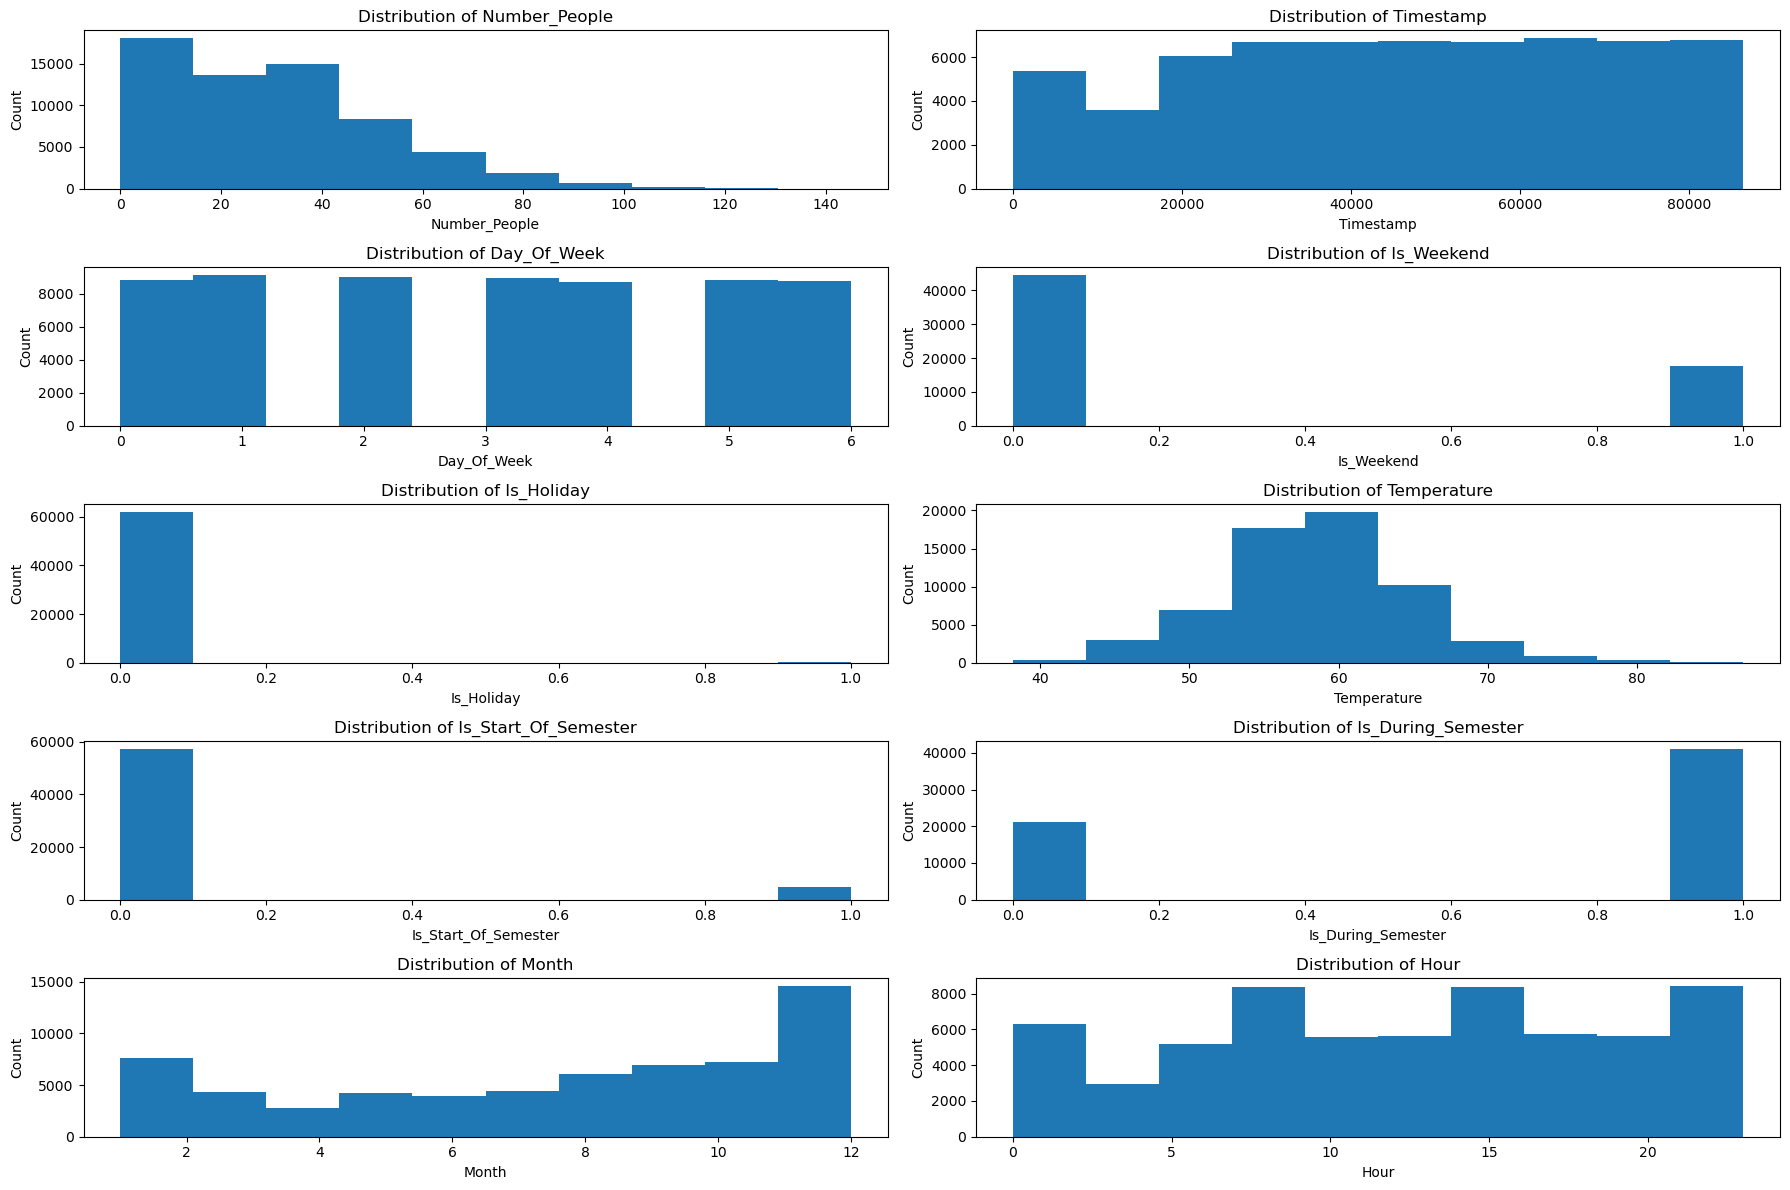

In [ ]:
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(gym.columns):
    ax = fig.add_subplot(5,2,i+1)
    ax.hist(gym[column])
    plt.ylabel('Count')
    plt.xlabel(column.title())
    plt.title(f"Distribution of {column.title()}")
    
plt.tight_layout()
plt.show()

So is_holiday is worthless because almost all of the points aren't a holiday. Could also say the same about start_of_semester. Let's now do some correlative work with our target variable. 

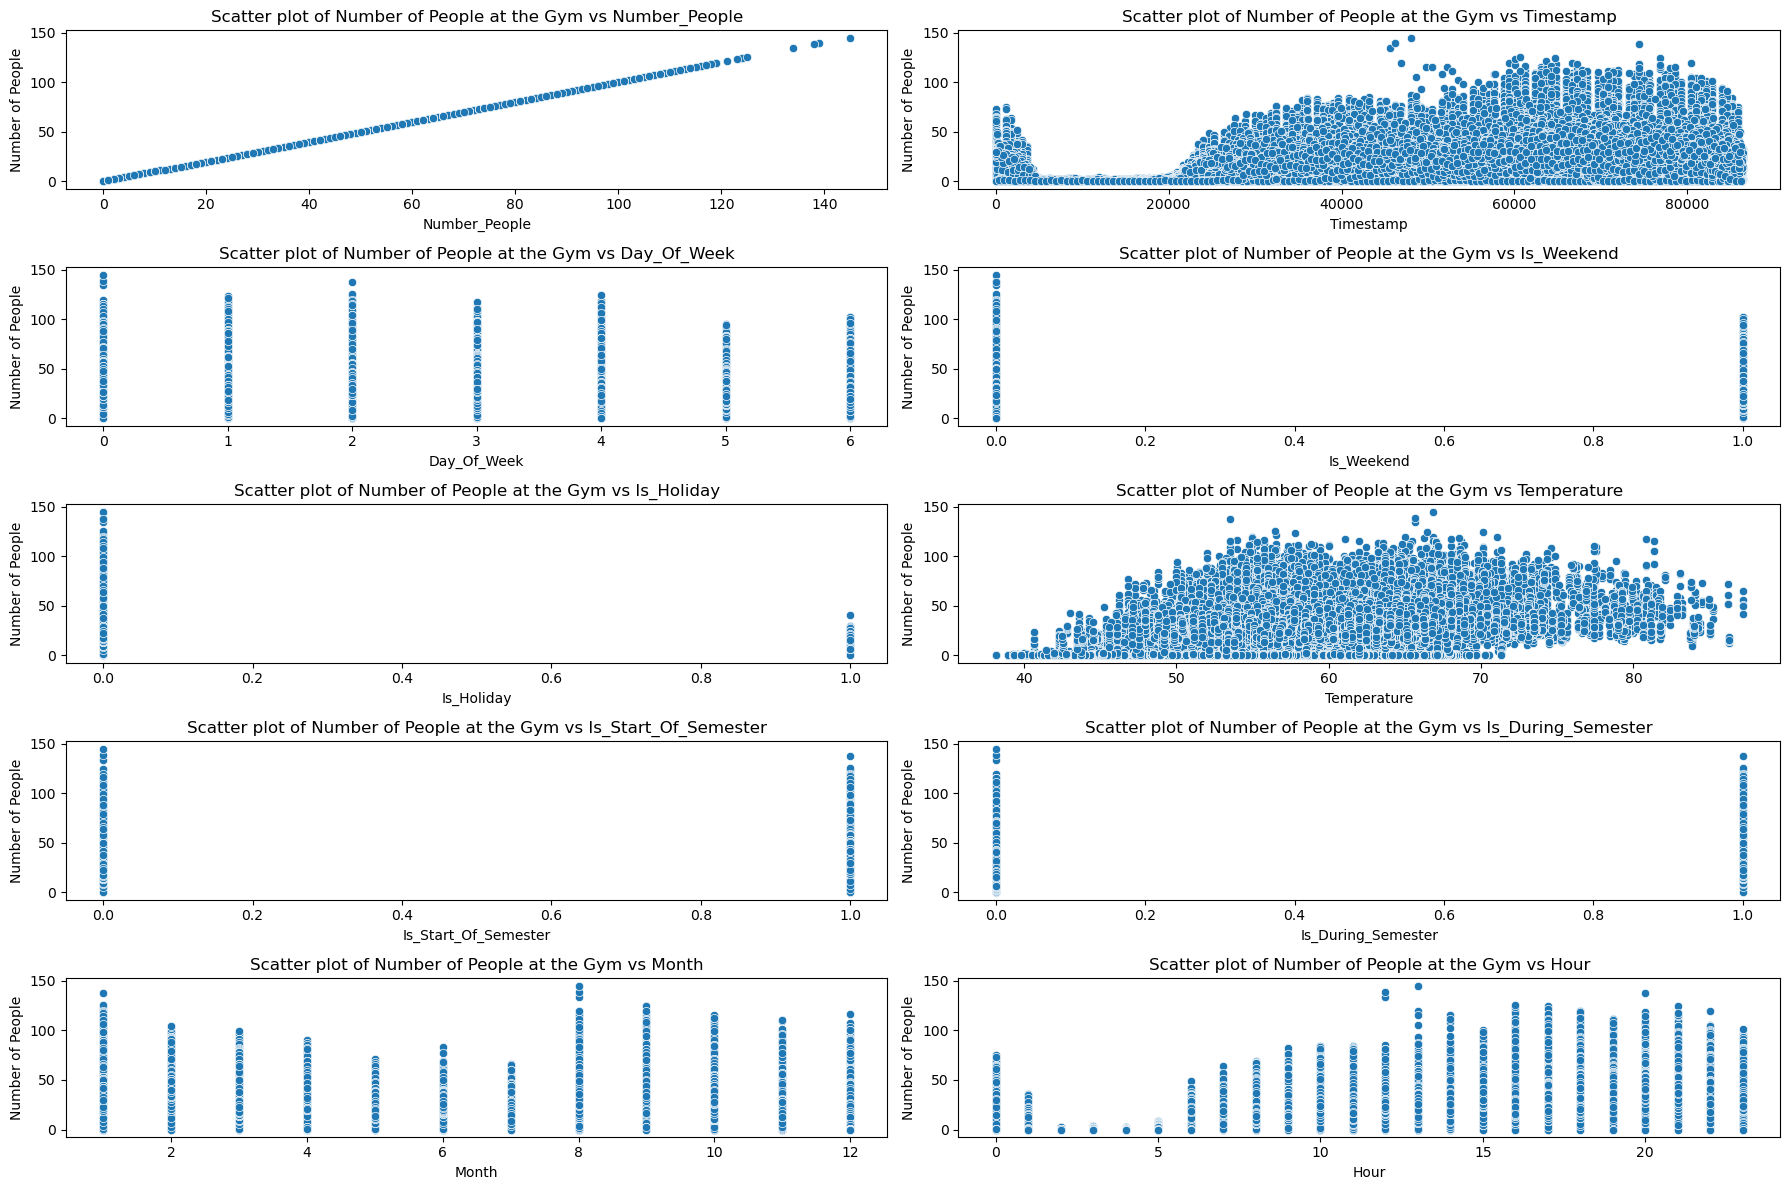

In [ ]:
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(gym.columns):
    ax = fig.add_subplot(5,2,i+1)
    sns.scatterplot(data = gym, x = gym[column], y = gym['number_people'], ax = ax)
    plt.ylabel('Number of People')
    plt.xlabel(column.title())
    plt.title(f"Scatter plot of Number of People at the Gym vs {column.title()}")
    
plt.tight_layout()
plt.show()

So people generally are at the gym less from months March-July than they are August-January and most people generally work out around 1pm - 12am. Some of these variables only have a handful of values and this plot didn't work out great for them, so let's make a boxplot for those. 

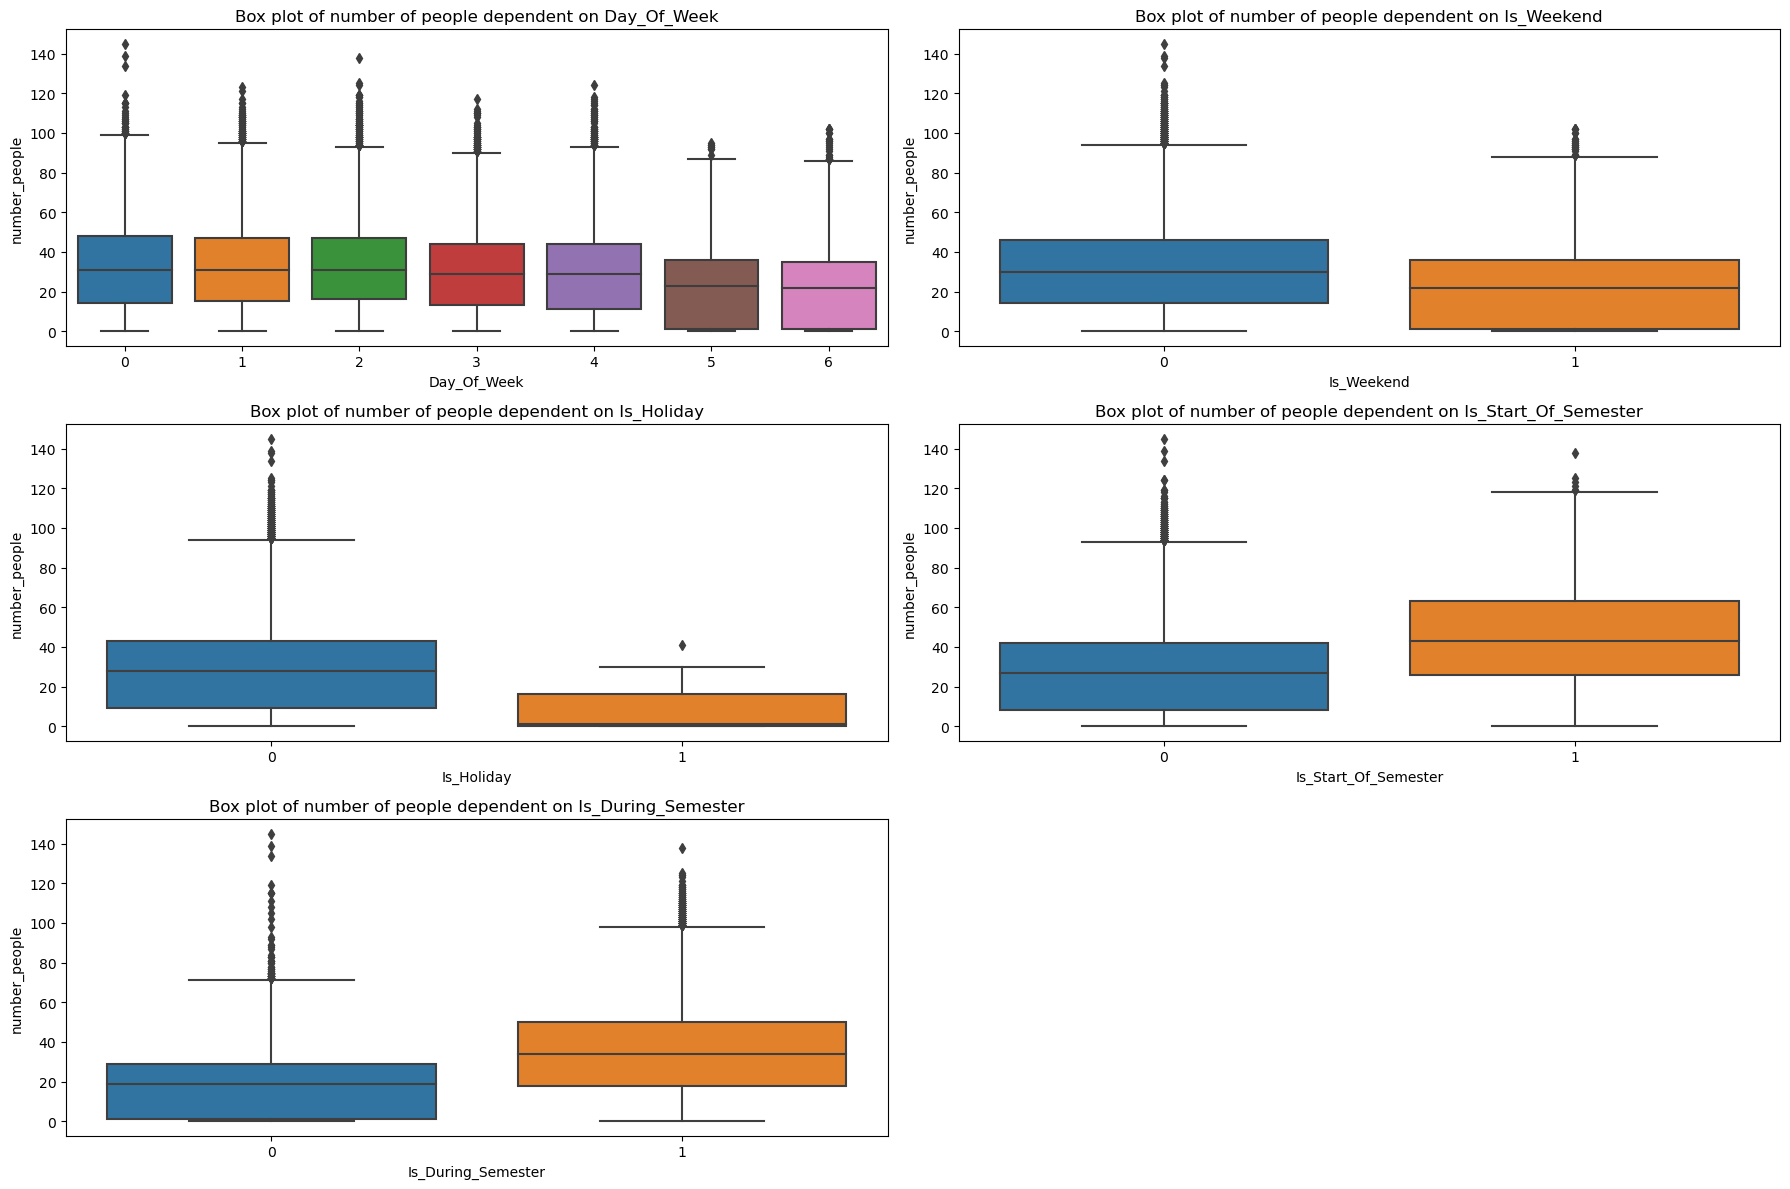

In [ ]:
few_values = gym[['day_of_week', 'is_weekend', 'is_holiday',
                  'is_start_of_semester', 'is_during_semester']]
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(few_values.columns):
    ax = fig.add_subplot(3,2,i+1)
    sns.boxplot(data = gym, x = gym[column], y = gym['number_people'])
    plt.title(f"Box plot of number of people dependent on {column.title()}")
    plt.xlabel(column.title())
plt.tight_layout()
plt.show()
    

There are three significant results from this:
- People don't work out when it's a holiday.
- Students work out more when it's the start of a semester.
- Students work out more often during the semester. 

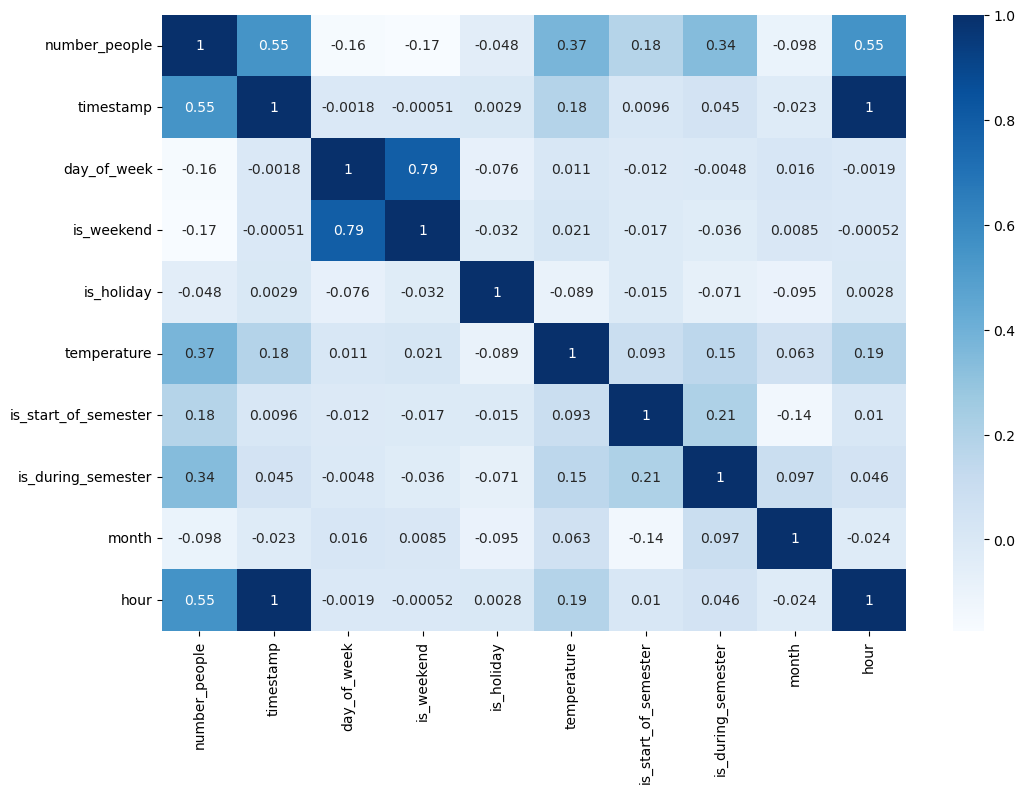

In [ ]:
fig = plt.figure(figsize = (12,8))
corr = gym.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True)
plt.show()

Here are the variables we can use for our model:
- temperature
- is_during_semester
- hour
- day_of_week
- is_weekend

I didn't include timestamp because it seems redundant, it's practically the same information as month/hour

## Training our Model

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
key_features = ['number_people','day_of_week',
                'is_weekend','temperature','is_during_semester',
                'hour']
X = gym[key_features].drop(columns = 'number_people', axis = 1)
y = gym['number_people']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0)

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
sgdr_1 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', 
    penalty='elasticnet', random_state = 52)
sgdr_2 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='epsilon_insensitive', 
    penalty='elasticnet', random_state = 52)
sgdr_3 = SGDRegressor(alpha=0.0001, learning_rate='constant', loss='epsilon_insensitive', 
    penalty='elasticnet', random_state = 52)
sgdr_4 = SGDRegressor(alpha=0.0001, learning_rate='constant', loss='huber', 
    penalty='elasticnet', random_state = 52)

In [96]:
sgdr_1.fit(X_train_scaled, y_train)
sgdr_2.fit(X_train_scaled, y_train)
sgdr_3.fit(X_train_scaled, y_train)
sgdr_4.fit(X_train_scaled, y_train)

SGDRegressor(learning_rate='constant', loss='huber', penalty='elasticnet',
             random_state=52)

## Testing our Model

In [97]:
y_pred_1 = sgdr_1.predict(X_test_scaled)
y_pred_2 = sgdr_2.predict(X_test_scaled)
y_pred_3 = sgdr_3.predict(X_test_scaled)
y_pred_4 = sgdr_4.predict(X_test_scaled)

In [98]:
for i in [y_pred_1,y_pred_2,y_pred_3,y_pred_4]:
    mse = mean_squared_error(y_test, i)
    rmse = mse**(1/2)
    score = r2_score(y_test, i)
    print(f"MSE: {mse}\nRMSE: {rmse}\nScore: {score}\n")

MSE: 269.71404678532326
RMSE: 16.42297314085739
Score: 0.4747987886257966

MSE: 271.2172108730152
RMSE: 16.46867362215352
Score: 0.47187174938123577

MSE: 270.8158761451072
RMSE: 16.456484319109816
Score: 0.4726532492244069

MSE: 268.78209810987545
RMSE: 16.39457526469885
Score: 0.47661352752841435



## Trying on all of the data

In [103]:
X = gym.drop(columns = ['number_people','timestamp'], axis = 1)
y = gym['number_people']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0)

In [105]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
sgdr_1.fit(X_train_scaled, y_train)
sgdr_2.fit(X_train_scaled, y_train)
sgdr_3.fit(X_train_scaled, y_train)
sgdr_4.fit(X_train_scaled, y_train)

SGDRegressor(learning_rate='constant', loss='huber', penalty='elasticnet',
             random_state=52)

In [107]:
y_pred_1 = sgdr_1.predict(X_test_scaled)
y_pred_2 = sgdr_2.predict(X_test_scaled)
y_pred_3 = sgdr_3.predict(X_test_scaled)
y_pred_4 = sgdr_4.predict(X_test_scaled)

In [108]:
for i in [y_pred_1,y_pred_2,y_pred_3,y_pred_4]:
    mse = mean_squared_error(y_test, i)
    rmse = mse**(1/2)
    score = r2_score(y_test, i)
    print(f"MSE: {mse}\nRMSE: {rmse}\nScore: {score}\n")

MSE: 256.4715210453576
RMSE: 16.014728253871734
Score: 0.5005853230802658

MSE: 257.34691207103623
RMSE: 16.04203578324884
Score: 0.49888071617309027

MSE: 258.2936129904556
RMSE: 16.071515578515164
Score: 0.4970372509342039

MSE: 256.6288780652079
RMSE: 16.019640385015137
Score: 0.5002789093119484



It actually does slightly better. But still a score of 50% is a bit shotty. 

## Visualizing
Let's visualize the best model, which seems to be the first model out of all the ones that used the full dataset.

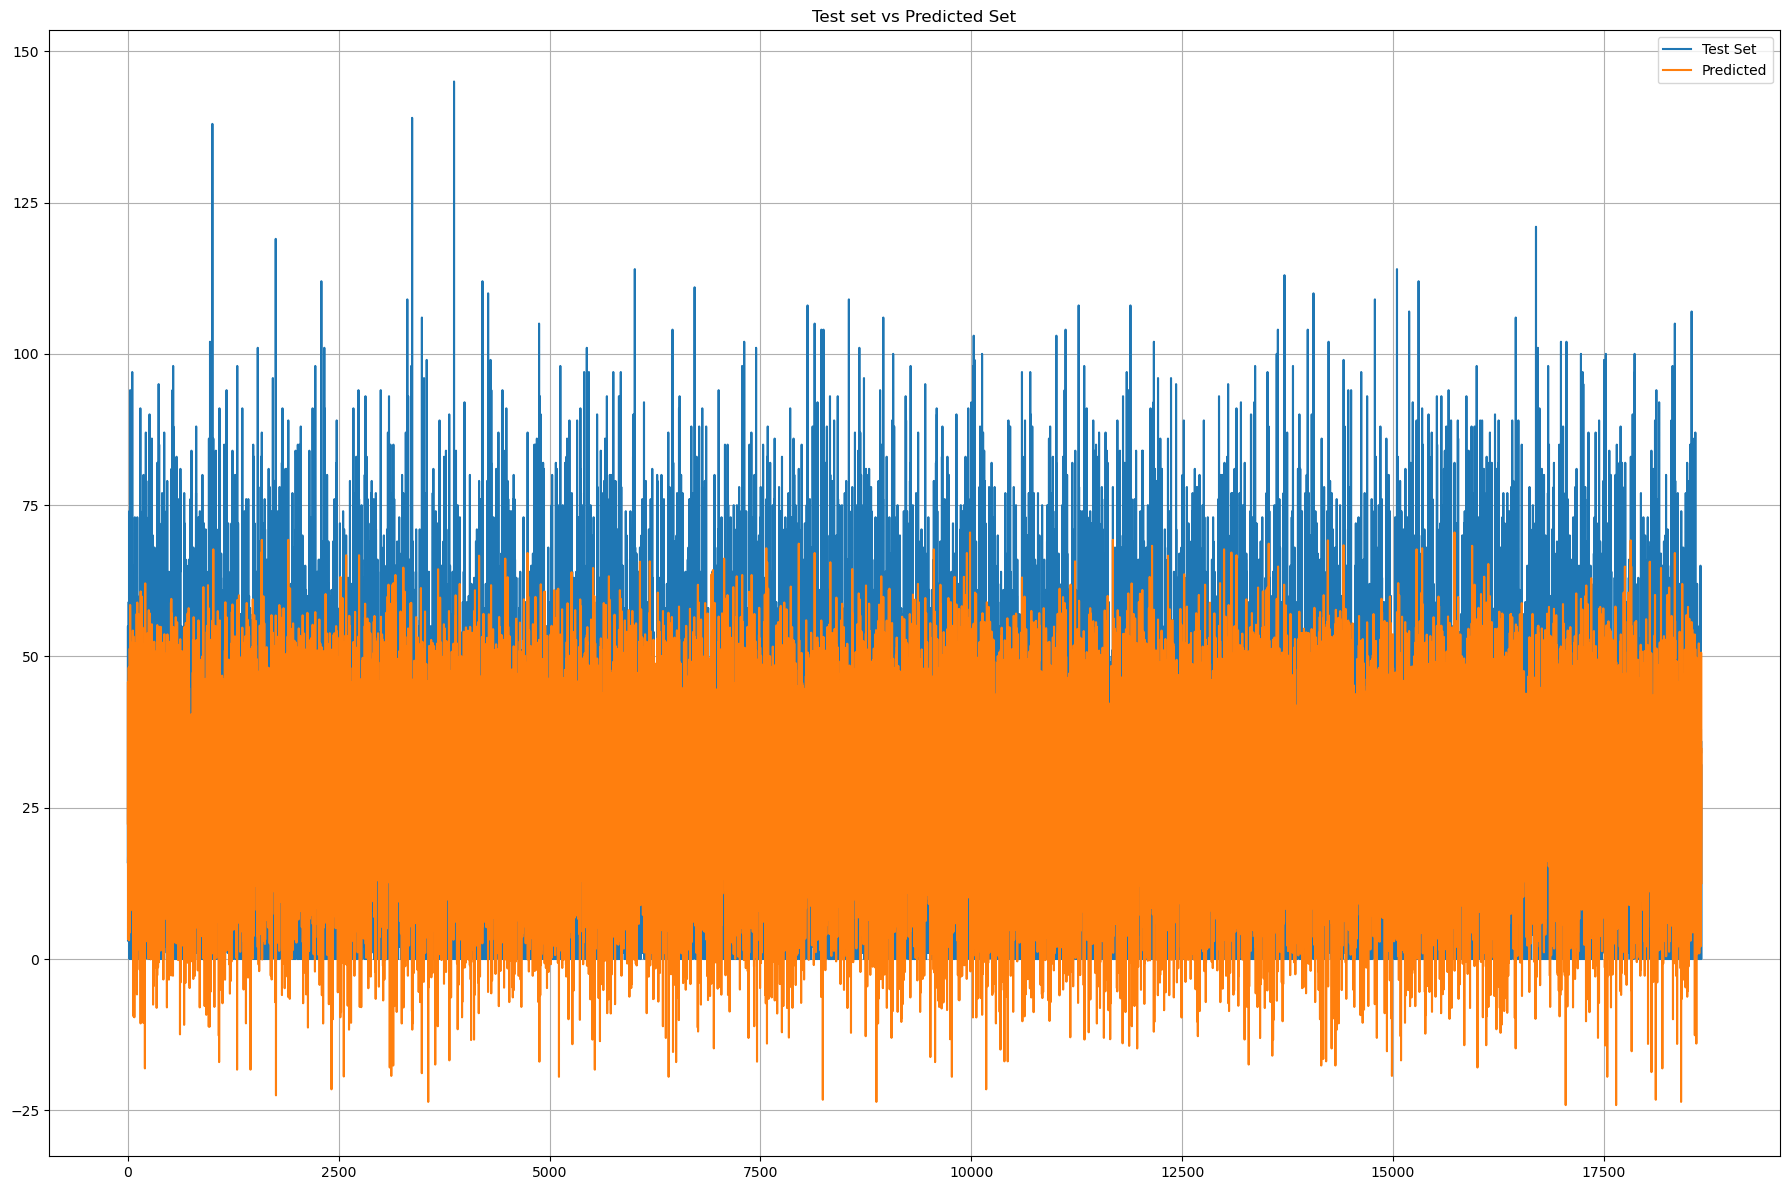

In [112]:
fig = plt.figure(figsize = (18,12))
ax = range(len(y_test))
plt.plot(ax, y_test, label = 'Test Set')
plt.plot(ax, y_pred_1, label = 'Predicted')
plt.legend()
plt.title('Test set vs Predicted Set')

plt.grid(True)

plt.tight_layout()
plt.show()

In [113]:
residuals = y_test - y_pred_1

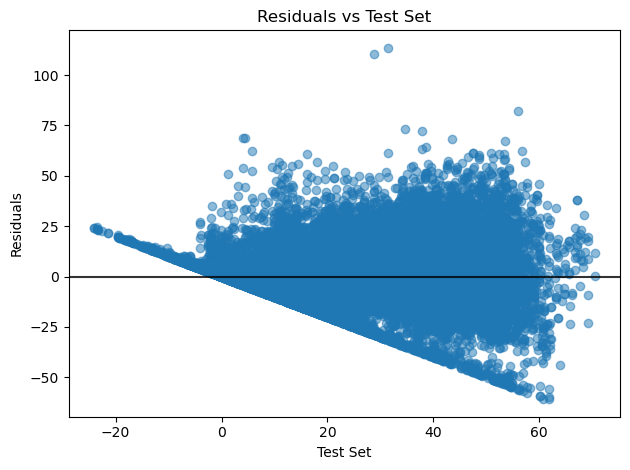

In [121]:
plt.scatter(y_pred_1, residuals, alpha = 0.5)
plt.axhline(0, color = 'black', alpha = 0.8)
plt.title('Residuals vs Test Set')
plt.ylabel('Residuals')
plt.xlabel('Test Set')
plt.tight_layout()
plt.show()

This kind of shows how our score was 0.5, the residuals are evenly split above and below the 0 line. 

## Evaluation
This model isn't great, 50% accuracy wouldn't be dependable in any probability/scoring test. I tried to use GridSearchCV to look for favorable parameters but it didn't work/stalled the IDE. 

Moving forward, I think it would be good to try using more variables even if I think they aren't useful if my model isn't performing well. Adding more variables in seemed to aid the model here slightly, even if they didn't show a ton of correlation. Looking back I think I forgot what I had done in my visualizations and choosing my key features I simply looked at the correlation heat map because it's easy to interpret. 